In [1]:
%matplotlib inline
%load_ext Cython
%load_ext heat
#http://people.duke.edu/~ccc14/sta-663-2016/18D_Cython.html

import matplotlib.pylab as plt
import random
import numpy as np
import time

## Example 1: Matrix Multiplication

#### Matrix Multiplication

Let's write a function to multiply 2 square (NxN) matrices together. 

First is out niave wave following the way we would do it by hand.

\begin{equation}
A =\begin{pmatrix}
 a_{11} & a_{12} & \cdots & a_{1m} \\
 a_{21} & a_{22} & \cdots & a_{2m} \\
\vdots & \vdots & \ddots & \vdots \\
 a_{n1} & a_{n2} & \cdots & a_{nm} \\
\end{pmatrix}
\end{equation}

\begin{equation}
B=\begin{pmatrix}
 b_{11} & b_{12} & \cdots & b_{1p} \\
 b_{21} & b_{22} & \cdots & b_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
 b_{m1} & b_{m2} & \cdots & b_{mp} \\
\end{pmatrix}
\end{equation}

\begin{equation}
C = AB
\end{equation}

\begin{equation}
C=\begin{pmatrix}
 c_{11} & c_{12} & \cdots & c_{1p} \\
 c_{21} & c_{22} & \cdots & c_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
 c_{n1} & c_{n2} & \cdots & c_{np} \\
\end{pmatrix}
\end{equation}

\begin{equation}
c_{ij} = a_{i1}b_{1j} + ... + a_{im}b_{mj} = \sum_{k=1}^m a_{ik}b_{kj}
\end{equation}

In [2]:
def mat_mul_py(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [3]:
size = 256
# Create two random matrix of size NxN (265x265)
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_py(A,B)

CPU times: user 13.5 s, sys: 56 ms, total: 13.6 s
Wall time: 13.7 s


### Now lets just add the cython magic line and see what happens

In [4]:
%%cython
# ^ This is the only thing we added

def mat_mul_cy(A, B):
    # Make a NxN matrix C, Filled with 0.0
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    # Loop over columns of A, and Rows of B
    for i in range(len(A)):
        # Loop over rows of A, and columns of B
        for j in range(len(A)):
            # Do final summation of each element
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [5]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy(A,B)

CPU times: user 7.9 s, sys: 77.3 ms, total: 7.98 s
Wall time: 8.04 s


#### Let's anotate the code to see where we can speed it up. 

##### More yellow means more generated C code. The less the C code the faster the code will be.

In [6]:
%%cython -a

def mat_mul_cy_fast(A, B):
    C = [[0.0 for i in range(len(A))] for j in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A)):
            for k in range(len(A)):
                C[i][j] += A[i][k] * B[k][j]
    return C

## 1) Give types to all of the variables

In [7]:
%%cython -a

# Arrays can be defined by the type and then [:] for 1d arrays
# 2d [:,:], 3d [:,:,:], etc.
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    # The loop variables and the size of the array are boths ints
    cdef int i,j,k = 0
    # c arrays have a new way to get lengths, shape
    cdef int size = A.shape[0]
    C = [[0.0 for i in range(size)] for j in range(size)]
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i][j] += A[i][k] * B[k][j]
    return C

In [8]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

CPU times: user 769 ms, sys: 6.59 ms, total: 775 ms
Wall time: 782 ms


## 2) Turn off some python features

In [9]:
%%cython -a

cimport cython

# Turn off the bounds checking and wrapping of python arrays
# NOTE: Now it is up to you to check to make sure you're not going past the length of the arrays
@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    C = [[0.0 for i in range(size)] for j in range(size)]
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i][j] += A[i, k] * B[k, j]
    return C

In [10]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

CPU times: user 525 ms, sys: 3.4 ms, total: 529 ms
Wall time: 533 ms


## 3) Make the output array a c array as well

In [11]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np
# A special type to make c style arrays
from cython.view cimport array

@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    # Define the output array as a c style array
    cdef double [:,:] C = array(shape=(size,size), itemsize=sizeof(double), format="d")
    C[:,:] = 0.0
    for i in range(size):
        for j in range(size):
            for k in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return np.asarray(C)

In [12]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

CPU times: user 47.1 ms, sys: 534 µs, total: 47.6 ms
Wall time: 49.7 ms


## Extra Credit: Why is this one faster? What did I change??

In [13]:
%%cython -a

cimport cython
import numpy as np
cimport numpy as np

from cython.view cimport array

@cython.boundscheck(False)
@cython.wraparound(False)
def mat_mul_cy_fast(double [:,:] A, double [:,:] B):
    cdef int i,j,k = 0
    cdef int size = A.shape[0]
    cdef double [:,:] C = array(shape=(size,size), itemsize=sizeof(double), format="d")
    C[:,:] = 0.0
    for i in range(size):
        for k in range(size):
            for j in range(size):
                C[i, j] += A[i, k] * B[k, j]
    return np.asarray(C)

In [14]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x = mat_mul_cy_fast(A,B)

CPU times: user 13.2 ms, sys: 113 µs, total: 13.3 ms
Wall time: 14.4 ms


### For simple operations though it's usully not worth doing

In [15]:
A = np.random.random((size,size))
B = np.random.random((size,size))
%time x1 = mat_mul_cy_fast(A, B)
%time x2 = np.matmul(A, B)

CPU times: user 14.7 ms, sys: 157 µs, total: 14.9 ms
Wall time: 15.5 ms
CPU times: user 3.28 ms, sys: 1.07 ms, total: 4.34 ms
Wall time: 2.55 ms


# Example 2: Wave Propogation

Let's try something more complex that doesn't have a function written for it already.

In this example we'll look at a 2d grid describing a pressure. In the center of the grid there is a forcing function taking the pressure values to $\,\pm$initial_P. This pressure propogated away from the center as the wave spreads out in all 4 directions (up,down,left,right). For each step we will calcuate the velocity of the wave in each direction and then the new pressure at each point. 

```python
for each step:
    # Calculate the pressure at the center for this stwp
    presure_at_center = initial_P * sin(omega * step)
    # Loop over rows
    for x in size_x:
        # Loop over columns
        for y in size_y
            # The velocity at each point is the difference between 
            # the pressure at the point and it's neighbor in a direction
            velocity_up[x][y]    += pressure[x][y] - pressure[x - 1][y]
            velocity_down[x][y]  += pressure[x][y] - pressure[x][y + 1]
            velocity_left[x][y]  += pressure[x][y] - pressure[x + 1][y]
            velocity_right[x][y] += pressure[x][y] - pressure[x][y - 1]
    # Now we recalculate the pressure for each point 
    # based on how pressure was lost to the velocities
    for x in size_x:
        for y in size_y
            pressure[x][y] -= sum(velocities)
```


It's ok if you don't totally understand the algorithm. We can take the same approach as we have before to try to speed up our code.

In [16]:
num_steps = 1000
scale = 256
damping= 0.25
initial_P = 250
stop_step = 100

In [17]:
def wave_propogation(num_steps, scale, damping, initial_P, stop_step):
    from math import pi, sin
    omega = 3 / (2 * pi)
    
    size_x = 2 * scale + 1
    size_y = 2 * scale + 1

    # V velocity
    # P presure
    # Initialization
    P = [[0.0 for x in range(size_x)] for y in range(size_y)]
    V = [[[0.0, 0.0, 0.0, 0.0] for x in range(size_x)] for y in range(size_y)]
    P[scale][scale] = initial_P
    for step in range(num_steps):
        if step <= stop_step:
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = (V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j])
                V[i][j][2] = (V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j])
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]

        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * sum(V[i][j])
    return P

5.87 Sec, 170.28 Hz


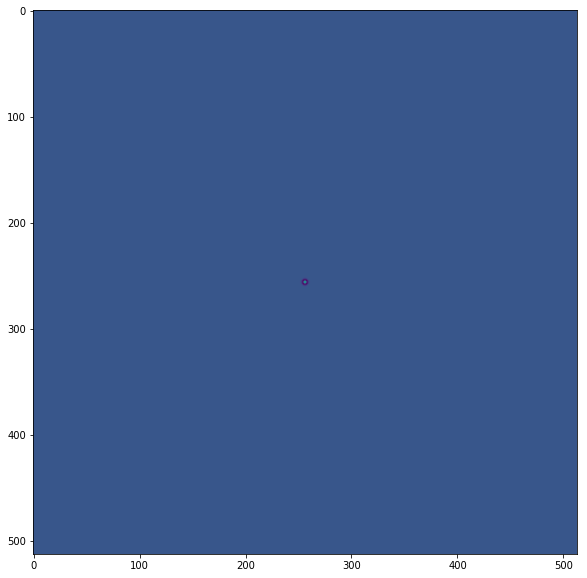

In [18]:
plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation(num_steps//100,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

In [19]:
%%cython -a
import time
# Import the c versions of pi and sin to speed up computations
from libc.math cimport M_PI as pi
from libc.math cimport sin as sin
cimport cython

cimport numpy as np
import numpy as np

# Using array to make C style array
from cython.view cimport array

# These turn off some python features for accessing arrays as python arrays
@cython.boundscheck(False)
@cython.wraparound(False)
# This turns off checks for divide by 0 and will seg fault instead of throw a warning
@cython.cdivision(True)
# Gave all the input variables types
def wave_propogation_fast(int num_steps, int scale,float damping,float initial_P,int stop_step):
    # Give types to variables we use to calculate with
    cdef float omega =  3.0 / (2.0 * pi)
    cdef int size_x = 2 * scale + 1
    cdef int size_y = 2 * scale + 1 
    
    # Give types to loop iterator variables to make loops C loops
    cdef int i = 0
    cdef int j = 0
    cdef int step = 0

    # Setup 
    cdef float [:,:] P = array(shape=(size_x, size_y), itemsize=sizeof(float), format="f")
    P[:,:] = 0.0
    cdef float [:,:,:] V = array(shape=(size_x, size_y, 4), itemsize=sizeof(float), format="f")
    V[:,:,:] = 0.0
    
    P[scale][scale] = initial_P
    
    for step in range(num_steps):
        if(step <= stop_step):
            P[scale][scale] = initial_P * sin(omega * step)
        for i in range(size_y):
            for j in range(size_x):
                V[i][j][0] = V[i][j][0] + P[i][j] - P[i - 1][j] if i > 0 else P[i][j]
                V[i][j][1] = V[i][j][1] + P[i][j] - P[i][j + 1] if j < size_x - 1 else P[i][j]
                V[i][j][2] = V[i][j][2] + P[i][j] - P[i + 1][j] if i < size_y - 1 else P[i][j]
                V[i][j][3] = V[i][j][3] + P[i][j] - P[i][j - 1] if j > 0 else P[i][j]
                
        for i in range(size_y):
            for j in range(size_x):
                P[i][j] -= 0.5 * damping * (V[i][j][0]+V[i][j][1]+V[i][j][2]+V[i][j][3])
    return np.asarray(P)

1.97 Sec, 508.75 Hz


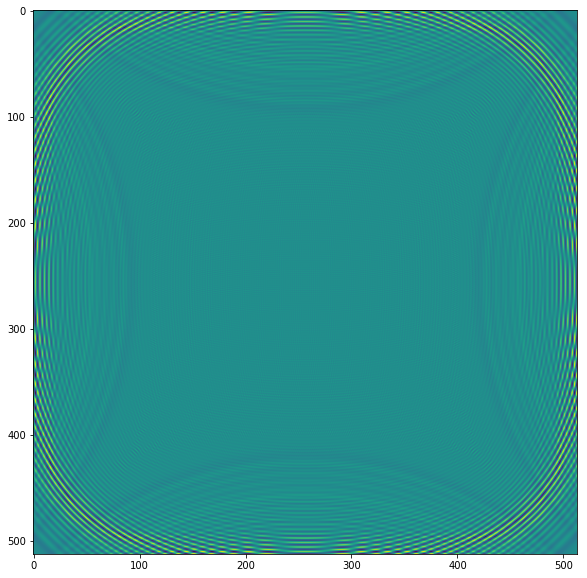

In [20]:
plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation_fast(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

### What if my code is already in c/c++?

#### Cython can take also take functions written in c/c++ and wrap them for use in python. Here is the same algorithm but now written in c++. 

Let's assume someone gave you this code or you found it online and you want to use it in your python program.


More details and the build systems for these examples are in the cython_tutorials folder.

### wp.cpp

<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-meta" style="color: rgb(199, 107, 41);">#<span class="hljs-meta-keyword">include</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span></span>

<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">void</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation_single_core</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> num_steps, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> scale, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> damping,
                                  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> initial_P, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> stop_step, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> *_P)</span> </span>{

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> omega = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.0</span> / (<span class="hljs-number" style="color: rgb(199, 107, 41);">2.0</span> * M_PI);
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>;

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> k = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">int</span> step = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> P[size_x][size_y];

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">float</span> V[size_x][size_y][<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>];

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
      P[i][j] = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>;
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (k = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; k &lt; <span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>; k++)
        V[i][j][k] = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>;
    }
  }

  P[scale][scale] = initial_P;
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (step = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; step &lt; num_steps; step++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> (step &lt;= stop_step)
      P[scale][scale] = initial_P * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">sin</span>(omega * step);
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] = (i &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] + P[i][j] - P[i - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>][j] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] = (j &lt; size_x - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] + P[i][j] - P[i][j + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] = (i &lt; size_y - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] + P[i][j] - P[i + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>][j] : P[i][j]);
        V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>] = (j &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span> ? V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>] + P[i][j] - P[i][j - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] : P[i][j]);
      }
    }

    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
      <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
        P[i][j] -= <span class="hljs-number" style="color: rgb(199, 107, 41);">0.5</span> * damping * (V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>] + V[i][j][<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>]);
      }
    }
  }

  <span class="hljs-comment" style="color: rgb(137, 142, 164);">// Then we copy from out array P into out output pointer _P</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; i &lt; size_x; i++) {
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> (j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>; j &lt; size_y; j++) {
      _P[i * size_x + j] = P[i][j];
    }
  }

}</pre>


#### Now we can just write a wrapper in cython.


### wave_propogation.pyx


<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> libc.stdlib cimport malloc, free
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cpython.mem cimport PyMem_Malloc
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> numpy <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> np
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> time
cimport cython
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cython.view cimport array <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> cvarray

cdef extern <span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span>:
  void wave_propogation_single_core(int, int, float, float, int, float*)

<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.boundscheck(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.cdivision(True)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.wraparound(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.infer_types(False)</span>
<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">def</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(int num_steps, int scale, float damping, float initial_P, int stop_step)</span>:</span>
  cdef int size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int i = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>
  cdef int j = <span class="hljs-number" style="color: rgb(199, 107, 41);">0</span>
  cdef float *array = &lt;float *&gt; malloc(sizeof(float) * size_x * size_y)
  wave_propogation_single_core(num_steps, scale, damping, initial_P, stop_step, array)
  P = [[<span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> x <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x)] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> y <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y)]

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> i <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x):
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> j <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y):
      P[i][j] = array[i*size_x+j] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">not</span> np.isnan(array[i*size_x+j]) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">else</span> <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">return</span> P</pre>

In [23]:
# And then build it
!cd cython_tutorial/chapter_3_cpp && rm -rf build && mkdir build && cd build && cmake .. && make -j2

-- The C compiler identification is AppleClang 10.0.1.10010046
-- The CXX compiler identification is AppleClang 10.0.1.10010046
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found PythonInterp: /usr/local/opt/python/libexec/bin/python (found version "3.7.3") 
-- Found Cython: /usr/local/bin/cython  
-- Found PythonLibs: /usr/local/Frameworks/Python.framework/Versions/3.7/lib/libpython3.7m.dylib (foun

1.75 Sec, 571.00 Hz


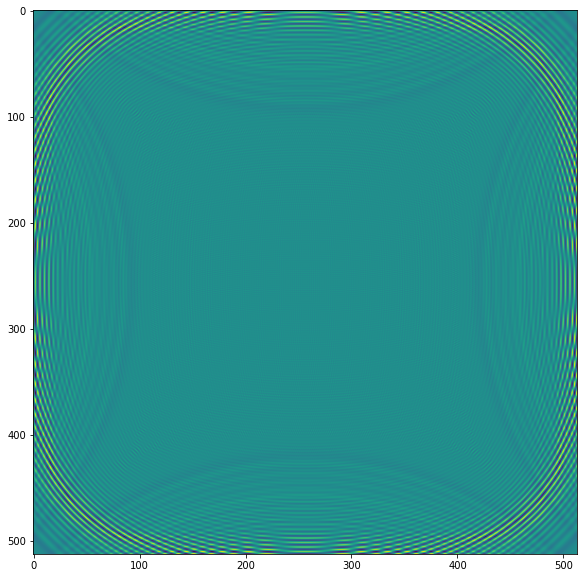

In [24]:
# Then import it just like a regular python module
import cython_tutorial.chapter_3_cpp.build.wave_propogation as wave_propogation

plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation.wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')

## And similarly with fortran...


<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">SUBROUTINE</span></span> wave_propogation(num_steps, <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>, damping, initial_P, stop_step, P)
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">IMPLICIT</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">NONE</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTEGER</span> size_x,size_Y,i,j,k,step
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span> PI, omega
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTEGER</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span>)  :: num_steps, <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>, stop_step <span class="hljs-comment" style="color: rgb(137, 142, 164);">!input</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span>) :: damping, initial_P <span class="hljs-comment" style="color: rgb(137, 142, 164);">!input</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">INTENT</span>(<span class="hljs-keyword" style="color: rgb(102, 121, 204);">out</span>) :: P(<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) <span class="hljs-comment" style="color: rgb(137, 142, 164);">! output</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">REAL</span>, <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DIMENSION</span>(<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) :: V

  size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  size_Y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span> + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>

  PI = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.14159</span>
  omega = <span class="hljs-number" style="color: rgb(199, 107, 41);">3.0</span> / (<span class="hljs-number" style="color: rgb(199, 107, 41);">2.0</span> * PI)

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> k=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           P(i,j) = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
           V(i,j,k) = <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

  P(<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>,<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>) = initial_P

  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> step = <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,num_steps
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">IF</span>(step &lt;= stop_step) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">THEN</span>
        P(<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>,<span class="hljs-built_in" style="color: rgb(199, 107, 41);">scale</span>) = initial_P * <span class="hljs-built_in" style="color: rgb(199, 107, 41);">SIN</span>(omega * step)
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">ENDIF</span>

     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) + P(i,j) - P(i - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,j), P(i,j), i &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) + P(i,j) - P(i,j + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>), P(i,j), j &lt; size_x - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) + P(i,j) - P(i + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,j), P(i,j), i &lt; size_y - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
           V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) = <span class="hljs-built_in" style="color: rgb(199, 107, 41);">MERGE</span>(V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>) + P(i,j) - P(i,j - <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>), P(i,j), j &gt; <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>)
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> j=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span> i=<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>,size_x
           P(i,j) = P(i,j) - <span class="hljs-number" style="color: rgb(199, 107, 41);">0.5</span> * damping * (V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">2</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">3</span>) + V(i,j,<span class="hljs-number" style="color: rgb(199, 107, 41);">4</span>))
        <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
     <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">DO</span>

<span class="hljs-keyword" style="color: rgb(102, 121, 204);">END</span> <span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">SUBROUTINE</span></span> wave_propogation</pre>





<pre class="hljs" style="display: block; overflow-x: auto; background: rgb(32, 39, 70); color: rgb(151, 157, 180); padding: 0.5em;"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> libc.stdlib cimport malloc, free
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cpython.mem cimport PyMem_Malloc
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> numpy <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> np
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">import</span> time
cimport cython
<span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> cython.view cimport array <span class="hljs-keyword" style="color: rgb(102, 121, 204);">as</span> cvarray

cdef extern <span class="hljs-keyword" style="color: rgb(102, 121, 204);">from</span> <span class="hljs-string" style="color: rgb(172, 151, 57);">"wp.hpp"</span>:
  void wave_propogation_(int*, int*, float*, float*, int*, float*)

<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.boundscheck(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.cdivision(True)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.wraparound(False)</span>
<span class="hljs-meta" style="color: rgb(199, 107, 41);">@cython.infer_types(False)</span>
<span class="hljs-function"><span class="hljs-keyword" style="color: rgb(102, 121, 204);">def</span> <span class="hljs-title" style="color: rgb(61, 143, 209);">wave_propogation</span><span class="hljs-params" style="color: rgb(199, 107, 41);">(int num_steps, int scale=<span class="hljs-number" style="color: rgb(199, 107, 41);">100</span>,float damping=<span class="hljs-number" style="color: rgb(199, 107, 41);">0.25</span>, float initial_P=<span class="hljs-number" style="color: rgb(199, 107, 41);">250.0</span>, int stop_step=<span class="hljs-number" style="color: rgb(199, 107, 41);">100</span>)</span>:</span>
  cdef int size_x = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int size_y = <span class="hljs-number" style="color: rgb(199, 107, 41);">2</span> * scale + <span class="hljs-number" style="color: rgb(199, 107, 41);">1</span>
  cdef int *_num_steps=&amp;num_steps
  cdef int *_scale=&amp;scale
  cdef float *_damping=&amp;damping
  cdef float *_initial_P=&amp;initial_P
  cdef int *_stop_step=&amp;stop_step

  cdef float *array = &lt;float *&gt; malloc(sizeof(float) * size_x * size_y)
  wave_propogation_(_num_steps, _scale, _damping, _initial_P, _stop_step, array)
  P = [[<span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> x <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x)] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> y <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y)]
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> i <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_x):
    <span class="hljs-keyword" style="color: rgb(102, 121, 204);">for</span> j <span class="hljs-keyword" style="color: rgb(102, 121, 204);">in</span> range(size_y):
      P[i][j] = array[i*size_x+j] <span class="hljs-keyword" style="color: rgb(102, 121, 204);">if</span> <span class="hljs-keyword" style="color: rgb(102, 121, 204);">not</span> np.isnan(array[i*size_x+j]) <span class="hljs-keyword" style="color: rgb(102, 121, 204);">else</span> <span class="hljs-number" style="color: rgb(199, 107, 41);">0.0</span>
  <span class="hljs-keyword" style="color: rgb(102, 121, 204);">return</span> P</pre>

In [25]:
# And then build it
!cd cython_tutorial/chapter_4_fortran && rm -rf build && mkdir build && cd build && cmake .. && make -j2

-- The C compiler identification is AppleClang 10.0.1.10010046
-- The CXX compiler identification is AppleClang 10.0.1.10010046
-- The Fortran compiler identification is GNU 8.3.0
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Checking whether Fortran compiler has -isysroot
-- Checking whether Fortran compiler has -isysroot - yes
-- Checking whether Fortran compiler supports OSX deployment target flag

7.65 Sec, 130.64 Hz


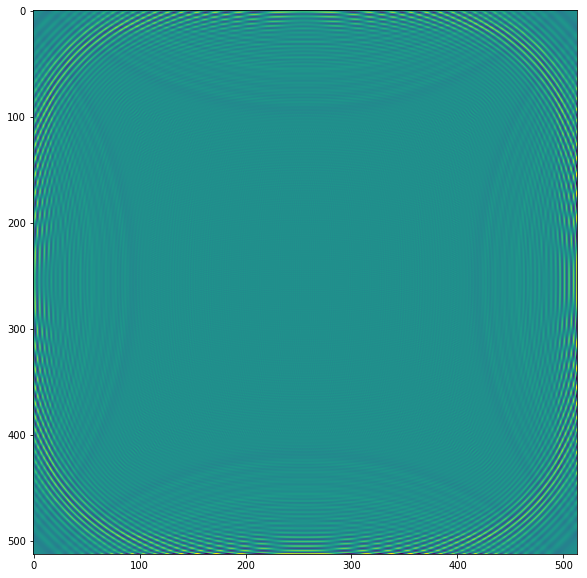

In [26]:
# Then import it just like a regular python module
import cython_tutorial.chapter_4_fortran.build.wave_propogation as wave_propogation

plt.figure(figsize=(10,10))
start = time.time()
pressure = wave_propogation.wave_propogation(num_steps,scale,damping,initial_P,stop_step)
stop = time.time()
print(f"{stop - start:.2f} Sec, {num_steps / (stop - start):.2f} Hz")
plt.imshow(pressure,cmap='viridis_r',interpolation='bilinear')